# Imports & Inits

In [ ]:
import os
from google.colab import drive
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

sns.set(style="whitegrid")

drive.mount('/content/gdrive/', force_remount=True)
# change location as per your convenience
os.chdir("/content/gdrive/Shareddrives/ECS 260/final/")

Mounted at /content/gdrive/


In [ ]:
conn = sqlite3.connect('final_database.db')

In [ ]:
# Read the SQLite database into a DataFrame
df = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'", conn)
df

,name
0,package_data
1,download_data
2,package_metrics
3,temp_table
4,metric_analysis


# Download Trends

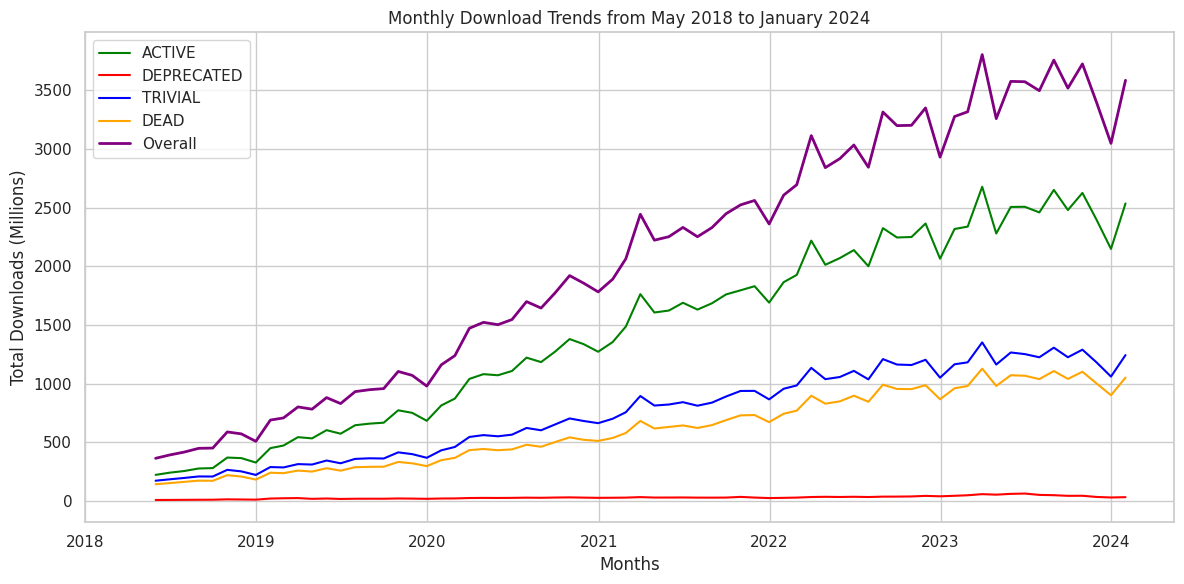

In [ ]:
# modify the SQL query to select specific columns from download_data table and the state column from the other table
query = "SELECT dd.*, ma.state FROM download_data AS dd INNER JOIN metric_analysis AS ma ON dd.package = ma.package"
df = pd.read_sql_query(query, conn)

# Drop the 'average' column from the DataFrame
df = df.drop(columns=['average'])

# Extract column names representing months and remove 'package' and 'average' columns
months = df.columns[1:-1]

# Remove the prefix 'm_' from the column names
months = months.str.replace('m_', '')

# Convert column names to datetime objects with correct format
months = pd.to_datetime(months, format='%Y%m')

# Find the earliest and latest months
earliest_month = months.min()
latest_month = months.max()

# Initialize lists to store data for plotting
state_lines = []

# Iterate over each state
for state, color in zip(['ACTIVE', 'DEPRECATED', 'TRIVIAL', 'DEAD', 'Overall'],
                        ['green', 'red', 'blue', 'orange', 'purple']):
    # Filter dataframe for the current state
    if state == 'Overall':
        state_df = df
    else:
        state_df = df[df['state'].apply(lambda x: state in x if x else False)]

    # Calculate total downloads for each month for the current state
    total_downloads_state = state_df.iloc[:, 1:-1].sum()

    # Convert total downloads to millions
    total_downloads_millions_state = total_downloads_state / 1000000  # 1 million = 1,000,000

    # Adjust x-values to represent the end of each month
    end_of_month = months + pd.offsets.MonthEnd(1)

    # Store the line for the current state
    state_lines.append((end_of_month, total_downloads_millions_state, state, color))

# Plot the line graph for each state
plt.figure(figsize=(12, 6))
for line in state_lines:
    if line[2] == 'Overall':
        plt.plot(line[0], line[1], color=line[3], linestyle='-', label=line[2], linewidth=2)
    else:
        plt.plot(line[0], line[1], color=line[3], linestyle='-', label=line[2])

# Adjust x-axis labels to start from January 2018
start_year = 2018
end_year = latest_month.year
plt.xticks(pd.date_range(start=str(start_year), end=str(end_year), freq='YS'), [str(year) for year in range(start_year, end_year + 1)])

# Set the title with earliest and latest month-year
plt.title('Monthly Download Trends from ' + earliest_month.strftime('%B %Y') + ' to ' + latest_month.strftime('%B %Y'))

plt.xlabel('Months')
plt.ylabel('Total Downloads (Millions)')
plt.legend()
plt.tight_layout()
plt.show()

# Monthly Growth Trends

## State-wise

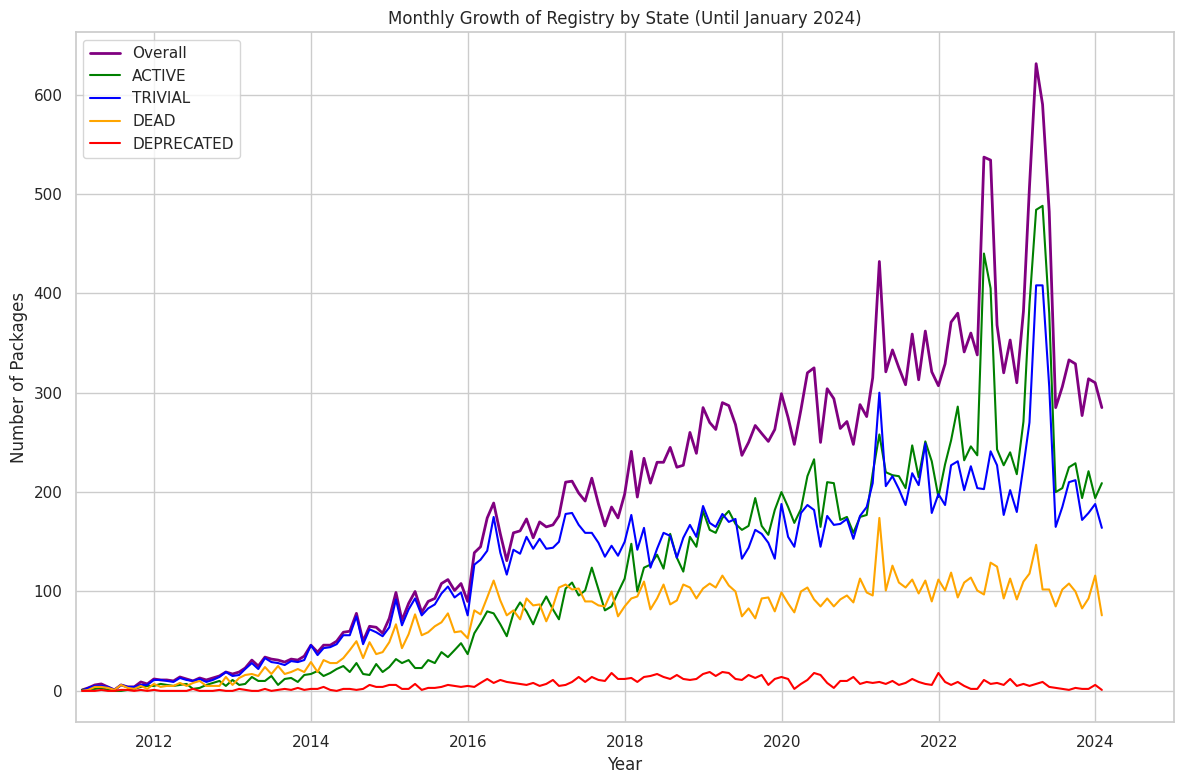

In [ ]:
# Read the SQLite database into a DataFrame
df = pd.read_sql_query("SELECT * FROM package_data INNER JOIN metric_analysis ON package_data.package = metric_analysis.package", conn)

# Convert 'created_timestamp' to datetime
df['created_timestamp'] = pd.to_datetime(df['created_timestamp'])

# Drop rows with NaT values in 'created_timestamp'
df = df.dropna(subset=['created_timestamp'])

# Filter data until January 31, 2024
df = df[df['created_timestamp'] <= '2024-01-31']

# Convert strings representing lists of states to actual lists of strings
df['state'] = df['state'].apply(lambda x: eval(x) if x is not None else [])

# Sort DataFrame by 'created_timestamp'
df.sort_values(by='created_timestamp', inplace=True)

# Resample data to count packages per month
monthly_package_count = df.resample('M', on='created_timestamp').size()

# Extract individual states from the 'state' column
states = df['state'].explode().dropna().unique()

# Resample data to count packages per month for each state
monthly_state_count = df.groupby(pd.Grouper(key='created_timestamp', freq='M'))['state'].apply(lambda x: x.explode().value_counts()).unstack(fill_value=0)

# Plotting
plt.figure(figsize=(12, 8))

# Plot overall monthly growth
# Adjust x-values to represent the end of each month
end_of_month = monthly_package_count.index + pd.offsets.MonthEnd(0)
plt.plot(end_of_month, monthly_package_count.values, linestyle='-', color='purple', label='Overall', linewidth=2)

# Plot monthly growth for each state
state_colors = {'ACTIVE': 'green', 'TRIVIAL': 'blue', 'DEAD': 'orange', 'DEPRECATED': 'red'}
for state in states:
    # Adjust x-values to represent the end of each month
    end_of_month = monthly_state_count[state].index + pd.offsets.MonthEnd(0)
    plt.plot(end_of_month, monthly_state_count[state].values, linestyle='-', color=state_colors.get(state, 'black'), label=state, linewidth=1.5)

# Set x-axis limits to start from the origin and end at the last month of 2025
plt.xlim(pd.Timestamp('2011-01-01'), pd.Timestamp('2025-01-01'))

plt.title('Monthly Growth of Registry by State (Until January 2024)')
plt.xlabel('Year')
plt.ylabel('Number of Packages')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Extract the latest 5 months
latest_months = monthly_package_count.tail(5)

# Print the month-year and total of the latest 5 months
for idx, (month_year, total) in enumerate(latest_months.iteritems(), start=1):
    print(f"Month {idx}: {month_year.strftime('%B %Y')} - Total: {total}")

Month 1: September 2023 - Total: 329
Month 2: October 2023 - Total: 277
Month 3: November 2023 - Total: 314
Month 4: December 2023 - Total: 310
Month 5: January 2024 - Total: 285


<ipython-input-24-1a87315007fc>:5: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for idx, (month_year, total) in enumerate(latest_months.iteritems(), start=1):


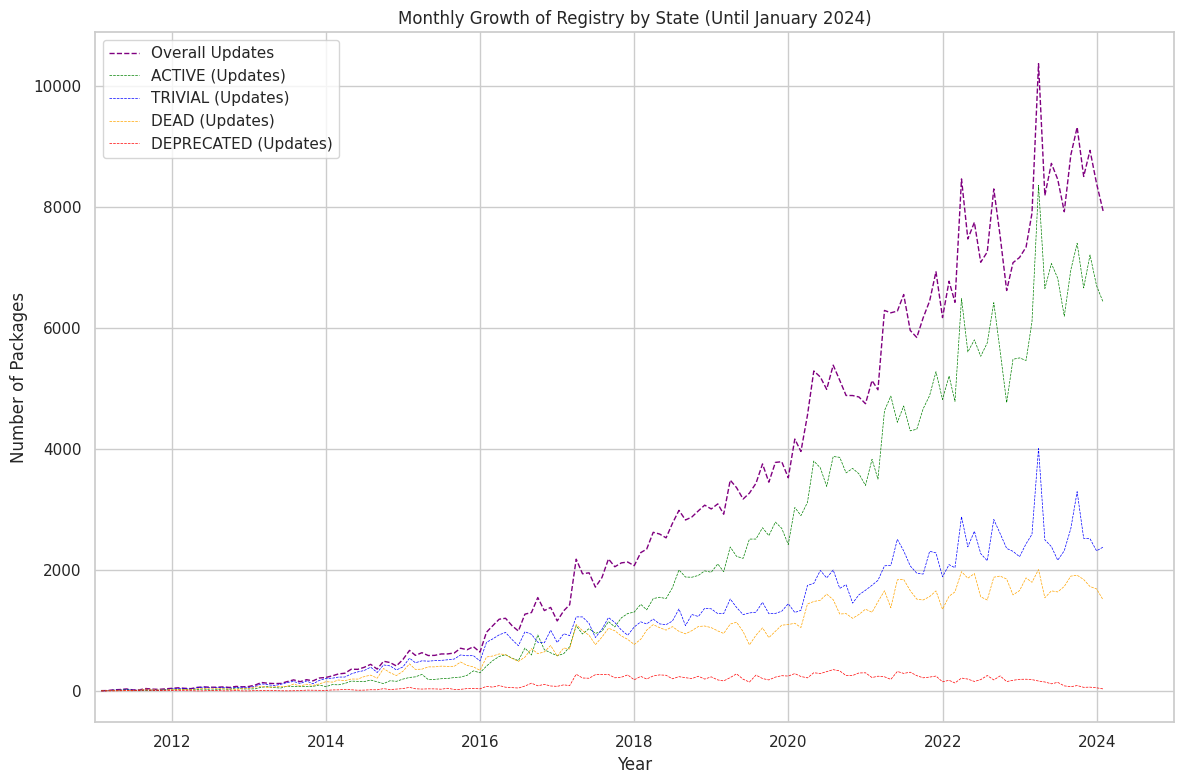

In [ ]:
# Read the SQLite database into a DataFrame
df = pd.read_sql_query("SELECT * FROM package_data INNER JOIN metric_analysis ON package_data.package = metric_analysis.package", conn)

# Convert 'created_timestamp' to datetime
df['created_timestamp'] = pd.to_datetime(df['created_timestamp'])

# Drop rows with NaT values in 'created_timestamp'
df = df.dropna(subset=['created_timestamp'])

# Filter data until January 31, 2024
df = df[df['created_timestamp'] <= '2024-01-31']
cutoff_date = pd.Timestamp('2024-01-31').tz_localize(None)  # Make timezone-naive

# Extracting package IDs and version history timestamps for monthly update count
package_ids = []
update_timestamps = []
package_states = []

# Convert strings representing lists of states to actual lists of strings
df['state'] = df['state'].apply(lambda x: eval(x) if x is not None else [])

for index, row in df.iterrows():
    package_id = index
    version_history = row['version_history_timestamps']
    curr_state = row['state']
    if version_history is not None:
        version_history = json.loads(version_history)
        for version, timestamp in version_history.items():
            timestamp = pd.to_datetime(timestamp).tz_localize(None)  # Make timezone-naive
            if timestamp <= cutoff_date:
                package_ids.append(package_id)
                update_timestamps.append(timestamp)
                package_states.append(curr_state)

update_df = pd.DataFrame({'package_id': package_ids, 'update_timestamp': update_timestamps, 'state': package_states})

# Sort DataFrame by 'created_timestamp'
df.sort_values(by='created_timestamp', inplace=True)
update_df.sort_values(by='update_timestamp', inplace=True)

# Resample data to count packages per month
monthly_package_count = df.resample('M', on='created_timestamp').size()
monthly_package_update_count = update_df.resample('M', on='update_timestamp').size()

# Extract individual states from the 'state' column
states = df['state'].explode().dropna().unique()

# Resample data to count packages per month for each state
monthly_state_count = df.groupby(pd.Grouper(key='created_timestamp', freq='M'))['state'].apply(lambda x: x.explode().value_counts()).unstack(fill_value=0)
monthly_state_update_count = update_df.groupby(pd.Grouper(key='update_timestamp', freq='M'))['state'].apply(lambda x: x.explode().value_counts()).unstack(fill_value=0)

update_df.resample('M', on='update_timestamp')['package_id'].nunique()

# Plotting
plt.figure(figsize=(12, 8))

# Plot overall monthly growth
# Adjust x-values to represent the end of each month
end_of_month = monthly_package_count.index + pd.offsets.MonthEnd(0)
# plt.plot(end_of_month, monthly_package_count.values, linestyle='-', color='purple', label='Overall Addition', linewidth=2)
plt.plot(end_of_month, monthly_package_update_count.values, linestyle='--', color='purple', label='Overall Updates', linewidth=1)

# Plot monthly growth for each state
state_colors = {'ACTIVE': 'green', 'TRIVIAL': 'blue', 'DEAD': 'orange', 'DEPRECATED': 'red'}
for state in states:
    # Adjust x-values to represent the end of each month
    end_of_month = monthly_state_count[state].index + pd.offsets.MonthEnd(0)
    # plt.plot(end_of_month, monthly_state_count[state].values, linestyle='-', color=state_colors.get(state, 'black'), label=f"{state} (Addition)", linewidth=1.5)
    plt.plot(end_of_month, monthly_state_update_count[state].values, linestyle='--', color=state_colors.get(state, 'black'), label=f"{state} (Updates)", linewidth=0.5)

# Set x-axis limits to start from the origin and end at the last month of 2025
plt.xlim(pd.Timestamp('2011-01-01'), pd.Timestamp('2025-01-01'))

plt.title('Monthly Growth of Registry by State (Until January 2024)')
plt.xlabel('Year')
plt.ylabel('Number of Packages')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Overall

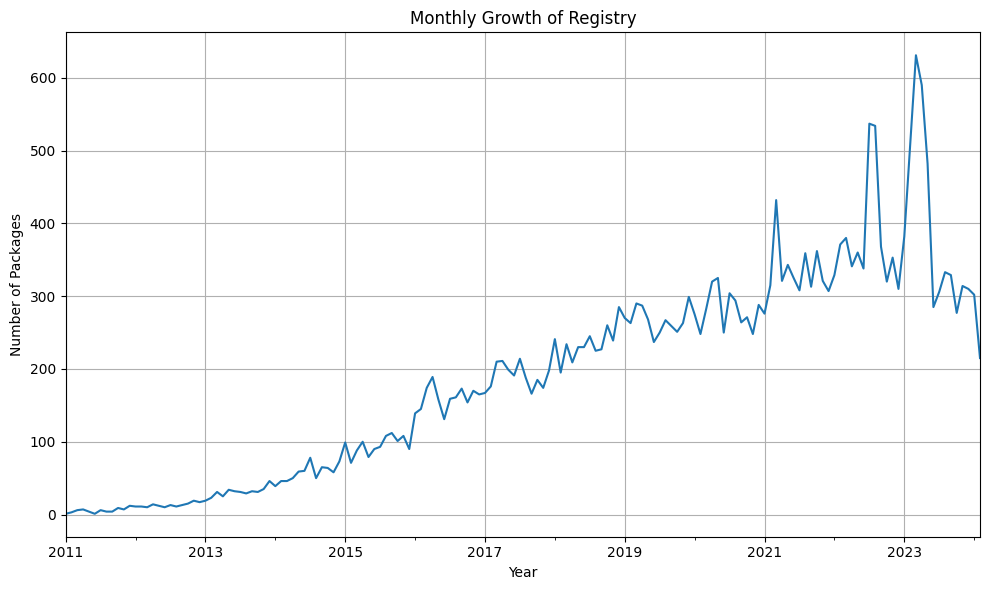

In [ ]:
# Read the SQLite database into a DataFrame
df = pd.read_sql_query("SELECT * FROM package_data INNER JOIN metric_analysis ON package_data.package = metric_analysis.package", conn)

# Convert 'created_timestamp' to datetime
df['created_timestamp'] = pd.to_datetime(df['created_timestamp'])

# Drop rows with NaT values in 'created_timestamp'
df = df.dropna(subset=['created_timestamp'])

# Sort DataFrame by 'created_timestamp'
df.sort_values(by='created_timestamp', inplace=True)


# Resample data to count packages per month
monthly_package_count = df.resample('M', on='created_timestamp').size()

# Plotting
plt.figure(figsize=(10, 6))
monthly_package_count.plot(linestyle='-')
plt.title('Monthly Growth of Registry')
plt.xlabel('Year')
plt.ylabel('Number of Packages')
plt.grid(True)
plt.tight_layout()
plt.show()

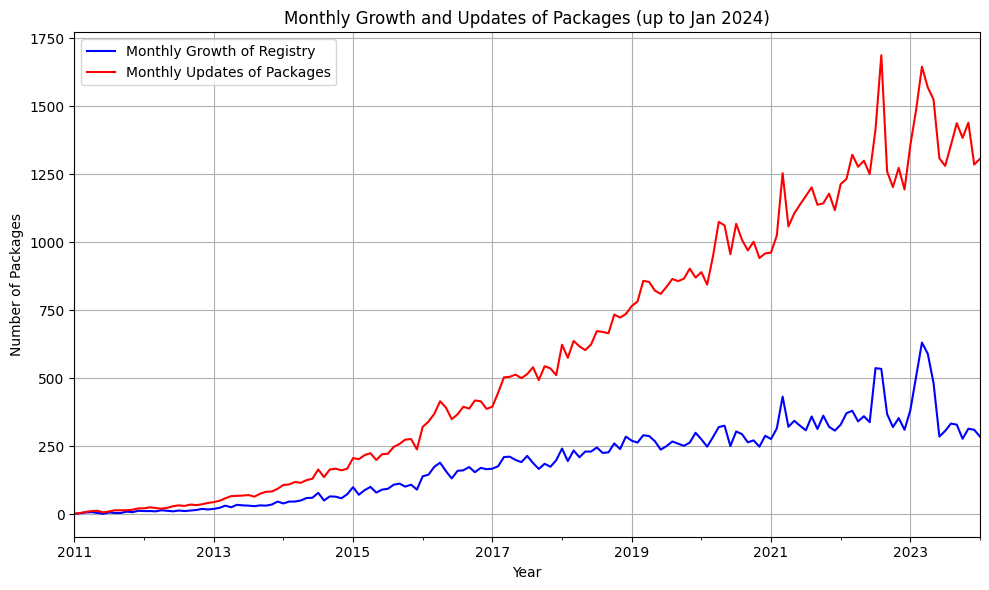

In [ ]:
# Assuming 'df' is the DataFrame containing the package data

# Convert 'created_timestamp' to datetime
df['created_timestamp'] = pd.to_datetime(df['created_timestamp'])

# Drop rows with NaT values in 'created_timestamp'
df = df.dropna(subset=['created_timestamp'])

# Sort DataFrame by 'created_timestamp'
df.sort_values(by='created_timestamp', inplace=True)

# Filter out dates after January 31, 2024
cutoff_date = pd.Timestamp('2024-01-31').tz_localize(None)  # Make timezone-naive
df = df[df['created_timestamp'].dt.tz_localize(None) <= cutoff_date]  # Make timezone-naive

# Resample data to count packages per month for monthly package count
monthly_package_count = df.resample('M', on='created_timestamp').size()

# Extracting package IDs and version history timestamps for monthly update count
package_ids = []
update_timestamps = []

for index, row in df.iterrows():
    package_id = index
    version_history = row['version_history_timestamps']
    if version_history is not None:
        version_history = json.loads(version_history)
        for version, timestamp in version_history.items():
            timestamp = pd.to_datetime(timestamp).tz_localize(None)  # Make timezone-naive
            if timestamp <= cutoff_date:
                package_ids.append(package_id)
                update_timestamps.append(timestamp)

# Creating a new DataFrame for monthly update count
update_df = pd.DataFrame({'package_id': package_ids, 'update_timestamp': update_timestamps})

# Resampling data to count updates per month
monthly_update_count = update_df.resample('M', on='update_timestamp')['package_id'].nunique()

# Plotting
plt.figure(figsize=(10, 6))

# Plot monthly package count
monthly_package_count.plot(linestyle='-', color='blue', label='Monthly Growth of Registry')

# Plot monthly update count
monthly_update_count.plot(linestyle='-', color='red', label='Monthly Updates of Packages')

plt.title('Monthly Growth and Updates of Packages (up to Jan 2024)')
plt.xlabel('Year')
plt.ylabel('Number of Packages')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
